In [8]:
import os
import matplotlib.pylab as plt
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub

print('version: ', tf.__version__)
print('Eager mode: ', tf.executing_eagerly())
print('Hub version: ', hub.__version__)
print('GPU is', 'available' if tf.test.is_gpu_available() else 'not avilable')

version:  2.3.1
Eager mode:  True
Hub version:  0.10.0
GPU is not avilable


## Select the Hub/TF2 module to use

In [9]:
module_selection = ("mobilenet_v2", 224, 1280) #@param ["(\"mobilenet_v2\", 224, 1280)", "(\"inception_v3\", 299, 2048)"] {type:"raw", allow-input: true}
handle_base, pixels, FV_SIZE = module_selection
MODULE_HANDLE ="https://tfhub.dev/google/tf2-preview/{}/feature_vector/4".format(handle_base)
IMAGE_SIZE = (pixels, pixels)
print("Using {} with input size {} and output dimension {}".format(
  MODULE_HANDLE, IMAGE_SIZE, FV_SIZE))

Using https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4 with input size (224, 224) and output dimension 1280


## Data preprocessing

Use [TensorFlow Datasets](http://tensorflow.org/datasets) to load the cats and dogs dataset.

This `tfds` package is the easiest way to load pre-defined data. If you have your own data, and are interested in importing using it with TensorFlow see [loading image data](../load_data/images.ipynb)


In [10]:
import tensorflow_datasets as tfds
#tfds.disable_progress_bar()

The `tfds.load` method downloads and caches the data, and returns a `tf.data.Dataset` object. These objects provide powerful, efficient methods for manipulating data and piping it into your model.

Since `"cats_vs_dog"` doesn't define standard splits, use the subsplit feature to divide it into (train, validation, test) with 80%, 10%, 10% of the data respectively.

In [11]:

(train_examples, validation_examples, test_examples), info = tfds.load(
    'cats_vs_dogs',
    data_dir='./data/tensorflow_datasets',
    split=['train[80%:]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True, 
    as_supervised=True, 
)

num_examples = info.splits['train'].num_examples
num_classes = info.features['label'].num_classes

Shuffling and writing examples to data/tensorflow_datasets/cats_vs_dogs/4.0.0.incompleteI4DYPL/cats_vs_dogs-train.tfrecord
Dataset cats_vs_dogs downloaded and prepared to ./data/tensorflow_datasets/cats_vs_dogs/4.0.0. Subsequent calls will reuse this data.


### Format the Data

Use the `tf.image` module to format the images for the task.

Resize the images to a fixes input size, and rescale the input channels

In [12]:
def format_image(image, label):
    image = tf.image.resize(image, IMAGE_SIZE) / 255.0
    return image, label

## Now shuffle and batch the data

In [13]:
BATCH_SIZE = 32 #@param {type:"integer"}

In [14]:
train_batches = train_examples.shuffle(num_examples // 4).map(format_image).batch(BATCH_SIZE).prefetch(1)
validation_batches = validation_examples.map(format_image).batch(BATCH_SIZE).prefetch(1)
test_batches = test_examples.map(format_image).batch(1)

Inspect a batch

In [15]:
for image_batch, label_batch in train_batches.take(1):
    pass
image_batch.shape

TensorShape([32, 224, 224, 3])

## Defining the model

All it takes is to put a linear classifier on top of the `feature_extractor_layer` with the Hub module.

For speed, we start out with a non-trainable `feature_extractor_layer`, but you can also enable fine-tuning for greater accuracy.

In [16]:
do_fine_tuning = True #@param {type:"boolean"}

Load TFHub Module

In [19]:
feature_extractor = hub.KerasLayer(MODULE_HANDLE,
                                   input_shape=IMAGE_SIZE + (3,), 
                                   output_shape=[FV_SIZE],
                                   trainable=do_fine_tuning)

In [20]:
print('building model with', MODULE_HANDLE)
model = tf.keras.Sequential([
    feature_extractor,
    tf.keras.layers.Dense(num_classes)
])
model.summary()

building model with https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 2)                 2562      
Total params: 2,260,546
Trainable params: 2,226,434
Non-trainable params: 34,112
_________________________________________________________________


In [21]:
# Unfreeze some layers

#@title (Optional) Unfreeze some layers
NUM_LAYERS = 7 #@param {type:"slider", min:1, max:50, step:1}
      
if do_fine_tuning:
  feature_extractor.trainable = True
  
  for layer in model.layers[-NUM_LAYERS:]:
    layer.trainable = True

else:
  feature_extractor.trainable = False

# Training the model

In [22]:
if do_fine_tuning:
  model.compile(
    optimizer=tf.keras.optimizers.SGD(lr=0.002, momentum=0.9), 
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'])
else:
  model.compile(
    optimizer='adam', 
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'])

In [23]:
EPOCHS = 5
hist = model.fit(train_batches,
                    epochs=EPOCHS,
                    validation_data=validation_batches)

Epoch 1/5
146/146 [==============================] - 635s 4s/step - loss: 0.2076 - accuracy: 0.9508 - val_loss: 0.0933 - val_accuracy: 0.9974
Epoch 2/5
146/146 [==============================] - 688s 5s/step - loss: 0.1083 - accuracy: 0.9912 - val_loss: 0.0876 - val_accuracy: 0.9996
Epoch 3/5
146/146 [==============================] - 668s 5s/step - loss: 0.0926 - accuracy: 0.9979 - val_loss: 0.0841 - val_accuracy: 1.0000
Epoch 4/5
146/146 [==============================] - 571s 4s/step - loss: 0.0906 - accuracy: 0.9983 - val_loss: 0.0842 - val_accuracy: 1.0000
Epoch 5/5
146/146 [==============================] - 2961s 20s/step - loss: 0.0890 - accuracy: 0.9979 - val_loss: 0.0835 - val_accuracy: 1.0000


# Export the Model

In [24]:
CATS_VS_DOGS_SAVED_MODEL = 'exp_saved_model'

Export the SavedModel

In [27]:
tf.saved_model.save(model, CATS_VS_DOGS_SAVED_MODEL)

INFO:tensorflow:Assets written to: exp_saved_model/assets
INFO:tensorflow:Assets written to: exp_saved_model/assets


In [28]:
%%bash -s $CATS_VS_DOGS_SAVED_MODEL
saved_model_cli show --dir $1 --tag_set serve --signature_def serving_default

The given SavedModel SignatureDef contains the following input(s):
  inputs['keras_layer_input'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1, 224, 224, 3)
      name: serving_default_keras_layer_input:0
The given SavedModel SignatureDef contains the following output(s):
  outputs['dense'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1, 2)
      name: StatefulPartitionedCall:0
Method name is: tensorflow/serving/predict


In [29]:
loaded = tf.saved_model.load(CATS_VS_DOGS_SAVED_MODEL)

In [30]:
print(list(loaded.signatures.keys()))
infer = loaded.signatures["serving_default"]
print(infer.structured_input_signature)
print(infer.structured_outputs)

['serving_default']
((), {'keras_layer_input': TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_layer_input')})
{'dense': TensorSpec(shape=(None, 2), dtype=tf.float32, name='dense')}


# Convert using TFLite's Converter

Load the TFLiteConverter with the SavedModel

In [31]:
converter = tf.lite.TFLiteConverter.from_saved_model(CATS_VS_DOGS_SAVED_MODEL)

### Post-training quantization
The simplest form of post-training quantization quantizes weights from floating point to 8-bits of precision. This technique is enabled as an option in the TensorFlow Lite converter. At inference, weights are converted from 8-bits of precision to floating point and computed using floating-point kernels. This conversion is done once and cached to reduce latency.

To further improve latency, hybrid operators dynamically quantize activations to 8-bits and perform computations with 8-bit weights and activations. This optimization provides latencies close to fully fixed-point inference. However, the outputs are still stored using floating point, so that the speedup with hybrid ops is less than a full fixed-point computation.

In [32]:
converter.optimizations = [tf.lite.Optimize.DEFAULT]

### Post-training integer quantization
We can get further latency improvements, reductions in peak memory usage, and access to integer only hardware accelerators by making sure all model math is quantized. To do this, we need to measure the dynamic range of activations and inputs with a representative data set. You can simply create an input data generator and provide it to our converter.

In [33]:
def representative_data_gen():
  for input_value, _ in test_batches.take(100):
    yield [input_value]

In [34]:
converter.representative_dataset = representative_data_gen

The resulting model will be fully quantized but still take float input and output for convenience.

Ops that do not have quantized implementations will automatically be left in floating point. This allows conversion to occur smoothly but may restrict deployment to accelerators that support float.

### Full integer quantization

To require the converter to only output integer operations, one can specify:

In [35]:
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]

### Finally convert the model

In [41]:
tflite_model = converter.convert()
tflite_model_file = './exp_saved_model/converted_model.tflite'

with open(tflite_model_file, "wb") as f:
  f.write(tflite_model)

### Test the TFLite model using the Python Interpreter

In [42]:
# Load TFLite model and allocate tensors.
  
interpreter = tf.lite.Interpreter(model_path=tflite_model_file)
interpreter.allocate_tensors()

input_index = interpreter.get_input_details()[0]["index"]
output_index = interpreter.get_output_details()[0]["index"]

In [43]:
from tqdm import tqdm

# Gather results for the randomly sampled test images
predictions = []

test_labels, test_imgs = [], []
for img, label in tqdm(test_batches.take(10)):
  interpreter.set_tensor(input_index, img)
  interpreter.invoke()
  predictions.append(interpreter.get_tensor(output_index))
  
  test_labels.append(label.numpy()[0])
  test_imgs.append(img)

100%|██████████| 10/10 [00:08<00:00,  1.15it/s]


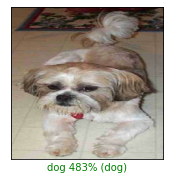

In [46]:
# Utility functions for plotting
#@title Utility functions for plotting
# Utilities for plotting

#@title Visualize the outputs { run: "auto" }
index = 2 #@param {type:"slider", min:0, max:9, step:1}
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(index, predictions, test_labels, test_imgs)
plt.show()

In [1]:
labels = ['cat', 'dog']

with open('labels.txt', 'w') as f:
  f.write('\n'.join(labels))